In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import seaborn as sns
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

In [65]:
plt.style.use('ggplot')
%matplotlib inline

In [66]:
zip_path = r"C:\Users\ADARSH UNIYAL\Downloads\archive.zip"

# We'll extract the data into a new folder called 'brain_tumor_data'
extract_dir = "brain_tumor_data"

In [67]:
data_dir = os.path.join(extract_dir, "brain_tumor_dataset")

# Define constants for the model
IMAGE_SIZE = (224, 224) # VGG19 was trained on 224x224 images
BATCH_SIZE = 32
EPOCHS = 15 # Y

In [68]:
try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        print(f"Extracting {zip_path} to {extract_dir}...")
        zip_ref.extractall(extract_dir)
    print("Extraction complete.")
except FileNotFoundError:
    print(f"Error: Zip file not found at {zip_path}")
    print("Please make sure the path is correct or place 'archive.zip' in the same directory as this notebook.")
except Exception as e:
    print(f"An error occurred during extraction: {e}")

Extracting C:\Users\ADARSH UNIYAL\Downloads\archive.zip to brain_tumor_data...
Extraction complete.


Total original images: 253
Tumorous (yes) images: 155
Non-tumorous (no) images: 98
Data is imbalanced: True


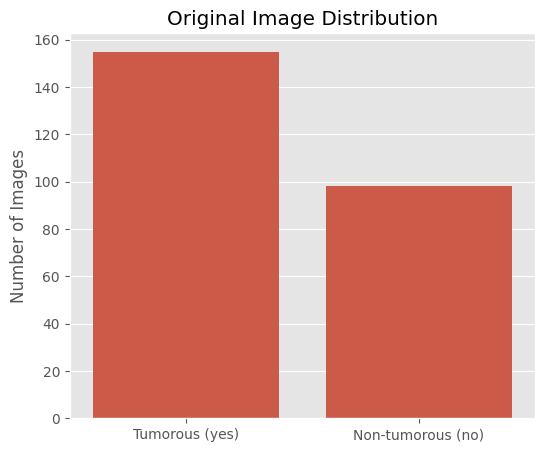

In [69]:
if os.path.exists(data_dir):
    yes_path = os.path.join(data_dir, 'yes')
    no_path = os.path.join(data_dir, 'no')

    # Count files
    num_yes_images = len(os.listdir(yes_path))
    num_no_images = len(os.listdir(no_path))
    total_images = num_yes_images + num_no_images

    print(f"Total original images: {total_images}")
    print(f"Tumorous (yes) images: {num_yes_images}")
    print(f"Non-tumorous (no) images: {num_no_images}")
    print(f"Data is imbalanced: {num_yes_images > num_no_images * 1.5 or num_no_images > num_yes_images * 1.5}")
    plt.figure(figsize=(6, 5))
    sns.barplot(x=['Tumorous (yes)', 'Non-tumorous (no)'], y=[num_yes_images, num_no_images])
    plt.title('Original Image Distribution')
    plt.ylabel('Number of Images')
    plt.show()
else:
    print(f"Error: Data directory not found at {data_dir}. Please check the zip file contents.")

In [70]:
train_datagen = ImageDataGenerator(
    rescale=1./255,            # Normalize pixel values
    validation_split=0.2,      # Hold back 20% for validation
    rotation_range=20,         # Randomly rotate images
    width_shift_range=0.1,     # Randomly shift width
    height_shift_range=0.1,    # Randomly shift height
    shear_range=0.1,           # Shear transformation
    zoom_range=0.1,            # Randomly zoom
    horizontal_flip=True,      # Randomly flip horizontally
    fill_mode='nearest'
)

In [71]:
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Create the generators from the directory
print("Creating Training Generator...")
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',       # 'binary' because we have two classes (yes/no)
    subset='training'          # This is the training set
)

Creating Training Generator...
Found 203 images belonging to 2 classes.


In [72]:
print("Creating Validation Generator...")
validation_generator = validation_datagen.flow_from_directory(
    data_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',       # This is the validation set
    shuffle=False              # No need to shuffle validation data
)

Creating Validation Generator...
Found 50 images belonging to 2 classes.


In [73]:
base_model = VGG19(
    weights='imagenet',
    include_top=False,         # Don't include the final Dense layer
    input_shape=IMAGE_SIZE + (3,) # Our image shape (224, 224, 3)
)

In [74]:
base_model.trainable = False

In [75]:
model = Sequential([
    base_model,                # Add the VGG19 base
    Flatten(),                 # Flatten the output to a 1D vector
    
    # Add our custom classifier head
    Dense(256, activation='relu'),
    Dropout(0.5),              # Dropout for regularization (prevents overfitting)
    Dense(1, activation='sigmoid') # Single output neuron with sigmoid (for binary classification)
])

In [76]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [77]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,447,425 (100.89 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [78]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
]

In [79]:
print("\nStarting Model Training...")
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=callbacks,
    # Steps per epoch = Total Train Images / Batch Size
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    # Validation steps = Total Validation Images / Batch Size
    validation_steps=validation_generator.samples // BATCH_SIZE
)
print("Training Complete.")


Starting Model Training...


c:\Users\ADARSH UNIYAL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.5208 - loss: 0.9663 - val_accuracy: 0.7500 - val_loss: 0.5352 - learning_rate: 1.0000e-04
Epoch 2/15
1/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.4688 - loss: 0.8561

c:\Users\ADARSH UNIYAL\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 287ms/step - accuracy: 0.4688 - loss: 0.8561 - val_accuracy: 0.7778 - val_loss: 0.5499 - learning_rate: 1.0000e-04
Epoch 3/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.6953 - loss: 0.6005 - learning_rate: 1.0000e-04
Epoch 4/15


c:\Users\ADARSH UNIYAL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
c:\Users\ADARSH UNIYAL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\callback_list.py:151: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 528ms/step - accuracy: 0.7188 - loss: 0.5866 - val_accuracy: 0.7188 - val_loss: 0.5276 - learning_rate: 1.0000e-04
Epoch 5/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.7083 - loss: 0.6463 - val_accuracy: 0.9444 - val_loss: 0.1757 - learning_rate: 1.0000e-04
Epoch 6/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7812 - loss: 0.4725 - learning_rate: 1.0000e-04
Epoch 7/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.6656 - loss: 0.6390 - val_accuracy: 0.7188 - val_loss: 0.5417 - learning_rate: 1.0000e-04
Epoch 8/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 289ms/step - accuracy: 0.6562 - loss: 0.5621 - val_accuracy: 0.8889 - val_loss: 0.3412 - learning_rate: 1.0000e-04
Epoch 9/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.7138 - loss: 0.5469 - learning_rate: 1.0000e-04
Epoch 10/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 525ms/step - accuracy: 0.8750 - loss: 0.3755 - val_accuracy: 0.6562 - val_loss: 0.6487 - learning_rate: 1.0000e-04
Epoch 11/15
6/6 ━━━━━━━━

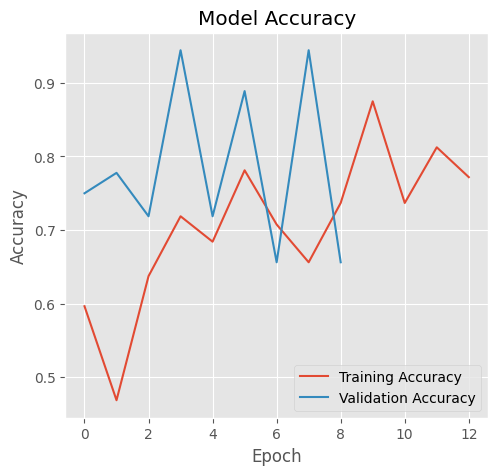

In [80]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

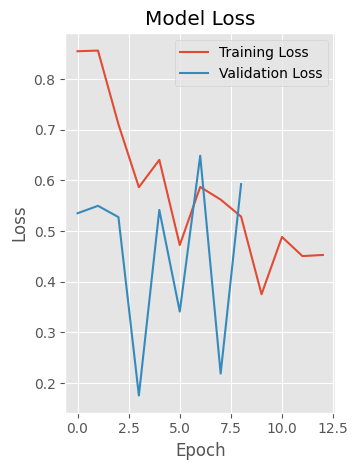

In [81]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [82]:
loss, accuracy = model.evaluate(validation_generator)
print(f"\nValidation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f} ({(accuracy * 100):.2f}%)")

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7254 - loss: 0.5511

Validation Loss: 0.4918
Validation Accuracy: 0.7600 (76.00%)


In [83]:
y_pred_prob = model.predict(validation_generator)
y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step


In [84]:
y_true = validation_generator.classes

# Ensure the lengths match (in case of incomplete batches)
# We'll just trim the predictions array to match the labels array
y_pred = y_pred[:len(y_true)]


--- Classification Report ---
              precision    recall  f1-score   support

          no       0.77      0.53      0.62        19
         yes       0.76      0.90      0.82        31

    accuracy                           0.76        50
   macro avg       0.76      0.71      0.72        50
weighted avg       0.76      0.76      0.75        50


--- Confusion Matrix ---


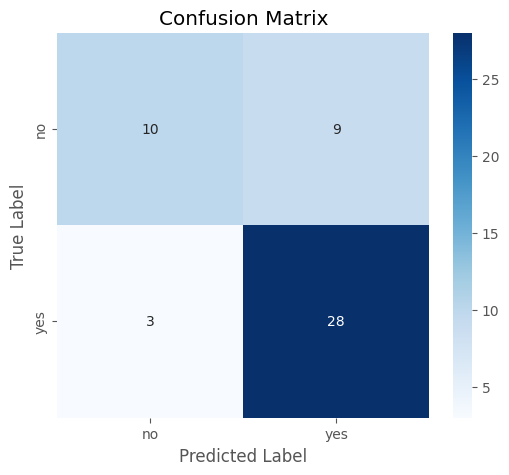

In [85]:
print("\n--- Classification Report ---")
target_names = [name for name, index in validation_generator.class_indices.items()]
print(classification_report(y_true, y_pred, target_names=target_names))

# Plot Confusion Matrix
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [87]:
model.save('brain_tumor_model.h5')
print("Model saved to 'brain_tumor_model.h5'")

Model saved to 'brain_tumor_model.h5'
